<a href="https://colab.research.google.com/github/Pratham-112/Multi-Indicator-Strategy-Backtester/blob/main/RSI_BOLL_SAR_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install backtrader

In [4]:
import numpy as np
import pandas as pd
import backtrader as bt
df = pd.read_csv("/content/NIFTY50.csv")
# Clean headers (remove stray spaces)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')
print(df.head())
print(df.columns.tolist())

                Open      High       Low     Close  Shares Traded  \
Date                                                                
2024-09-18  25402.40  25482.20  25285.55  25377.55      215727159   
2024-09-19  25487.05  25611.95  25376.05  25415.80      314461263   
2024-09-20  25525.95  25849.25  25426.60  25790.95      533067422   
2024-09-23  25872.55  25956.00  25847.35  25939.05      209187756   
2024-09-24  25921.45  26011.55  25886.85  25940.40      384115033   

            Turnover (₹ Cr)  
Date                         
2024-09-18         28832.00  
2024-09-19         34389.27  
2024-09-20         68915.27  
2024-09-23         24825.74  
2024-09-24         35573.63  
['Open', 'High', 'Low', 'Close', 'Shares Traded', 'Turnover (₹ Cr)']


/tmp/ipython-input-1867528091.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [5]:
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),          # use index as datetime
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Shares Traded'),
        ('openinterest', None),
    )

In [6]:
import inspect

class RsiBollSarStrategy(bt.Strategy):
    params = dict(
        rsi_period=14,
        bb_period=20,
        bb_dev=2.0,
        sar_step=0.02,
        sar_max=0.2,
        rsi_lower=35,      # was 30 → higher to trigger more often
        rsi_lower_for_sar=25,
        rsi_upper=65,      # was 70 → exit sooner
    )

    def __init__(self):
        self.rsi = bt.ind.RSI(period=self.p.rsi_period)
        self.bb  = bt.ind.BollingerBands(period=self.p.bb_period,
                                         devfactor=self.p.bb_dev)

        # Robust SAR for various BT versions
        SAR = bt.ind.ParabolicSAR
        sig = inspect.signature(SAR.__init__)
        if 'af' in sig.parameters:
            self.sar = SAR(af=self.p.sar_step, afmax=self.p.sar_max)
        elif 'acc' in sig.parameters:
            self.sar = SAR(acc=self.p.sar_step, afmax=self.p.sar_max)
        elif 'step' in sig.parameters and 'max' in sig.parameters:
            self.sar = SAR(step=self.p.sar_step, max=self.p.sar_max)
        else:
            self.sar = SAR()

        self.bb_top = self.bb.lines.top
        self.bb_bot = self.bb.lines.bot

    def next(self):
        price = self.data.close[0]

        # ----- ENTRY -----
        if not self.position:
            # Condition 1: oversold inside lower band
            cond1 = (self.rsi[0] < self.p.rsi_lower and price < self.bb_bot[0])
            # Condition 2: price breaking above SAR (trend up)
            cond2 = (self.rsi[0] < self.p.rsi_lower_for_sar and price > self.sar[0])

            if cond1 or cond2:
                self.buy()

        # ----- EXIT -----
        else:
            # exit if overbought or hit upper band or dropped below SAR
            if (self.rsi[0] > self.p.rsi_upper or
                price > self.bb_top[0] or
                price < self.sar[0]):
                self.close()



=== Performance ===
Start Value: 1000000.0
End Value  : 992144.4418446536

Sharpe: OrderedDict({'sharperatio': -1.4797171526966242})
Drawdown: AutoOrderedDict({'len': 207, 'drawdown': 0.8495366311958523, 'moneydown': 8500.848288013018, 'max': AutoOrderedDict({'len': 207, 'drawdown': 1.3990104892435715, 'moneydown': 13999.132569077774})})
Returns : OrderedDict({'rtot': -0.007886575598651167, 'ravg': -3.167299437209304e-05, 'rnorm': -0.007949826232615644, 'rnorm100': -0.7949826232615644})
Trades  : AutoOrderedDict({'total': AutoOrderedDict({'total': 6, 'open': 0, 'closed': 6}), 'streak': AutoOrderedDict({'won': AutoOrderedDict({'current': 1, 'longest': 1}), 'lost': AutoOrderedDict({'current': 0, 'longest': 2})}), 'pnl': AutoOrderedDict({'gross': AutoOrderedDict({'total': 3537.6448509093834, 'average': 589.6074751515639}), 'net': AutoOrderedDict({'total': -7855.558155346498, 'average': -1309.2596925577498})}), 'won': AutoOrderedDict({'total': 3, 'pnl': AutoOrderedDict({'total': 7707.1573

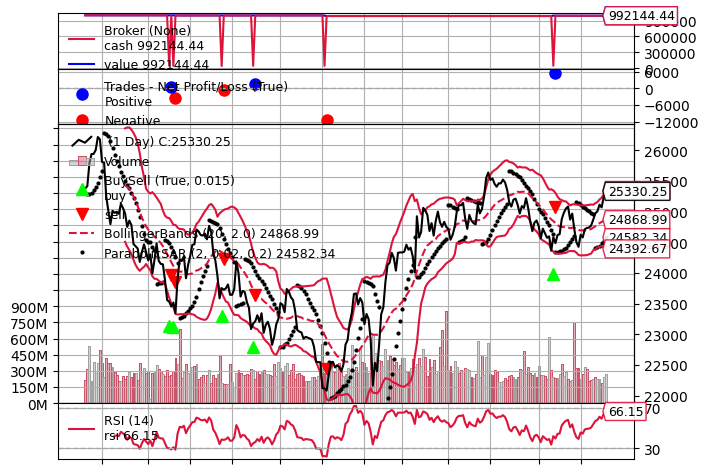

In [7]:
def run_backtest(
    df,
    cash=1_000_000,
    commission=0.001,        # 0.1%
    percents=95,             # invest 95% of cash each trade
    plot=True
):
    cerebro = bt.Cerebro()

    # Feed
    feed = PandasData(dataname=df)
    cerebro.adddata(feed)

    # Strategy
    cerebro.addstrategy(RsiBollSarStrategy)

    # Broker & Sizer
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)
    cerebro.addsizer(bt.sizers.PercentSizer, percents=percents)

    # --- Add analyzers BEFORE run ---
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe',
                        timeframe=bt.TimeFrame.Days, annualize=True)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')

    results = cerebro.run()
    strat = results[0]

    # Stats
    print("\n=== Performance ===")
    print("Start Value:", float(cash))
    print("End Value  :", float(cerebro.broker.getvalue()))

    print("\nSharpe:", strat.analyzers.sharpe.get_analysis())
    print("Drawdown:", strat.analyzers.drawdown.get_analysis())
    print("Returns :", strat.analyzers.returns.get_analysis())
    print("Trades  :", strat.analyzers.trades.get_analysis())
    print("SQN     :", strat.analyzers.sqn.get_analysis())

    if plot:
        # In Colab, iplot=False avoids interactive backend quirks
        cerebro.plot(iplot=False)

    return strat

_ = run_backtest(df, plot=True)